# Tutorial to Work with a NUCAPS (NOAA-20) Sounding data file

This code was written in December 2022 by Dr. Rebekah Esmaili, STC at NOAA/JPSS (rebekah.esmaili@noaa.gov) and Dr. Amy Huff, IMSG at NOAA/NESDIS/STAR (amy.huff@noaa.gov).

This tutorial will demonstrate how to work with a NUCAPS Level 2 netCDF4 file, including how to work with multiple pressure levels.

The main steps are:
- Open the file
- Read the global file metadata & the metadata for variables in the file
- Extract a profile and make a Skew-T plot
- Save image file


## Import Python packages

We will use three Python packages (libraries) and two Python modules in this tutorial:
- The **xarray** library is used to work with labelled multi-dimensional arrays
- The **NumPy** library is used to perform array operations
- The **Matplotlib** library is used to make plots
- The **datetime** module is used to manipulate dates and times
- The **pathlib** module is used to set filesystem paths for the user's operating system

In [48]:
import xarray as xr

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from pathlib import Path

import cartopy.crs as ccrs

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import SkewT

## Set directory path and file name for satellite data file

We set the directory path for the satellite data file using the **pathlib** module, which automatically uses the correct format for the user's operating system. This helps avoid errors in situations when more than one person is using the same code file, because Windows uses back slashes in directory paths, while MacOS and Linux use forward slashes. 

More information about the [**pathlib** module](https://docs.python.org/3/library/pathlib.html#module-pathlib).

To keep things simple for this training, we put the satellite data files we downloaded in the current working directory ("cwd"), i.e., the same Jupyter Notebook folder where this code file is located.

We set the "directory_path" as the current working directory and the "file_name" of the netCDF4 satellite data file, and then set the full path for the data file ("file_id") using **pathlib** syntax.

In [49]:
directory_path = Path.cwd()
file_name = 'NUCAPS-EDR_v3r0_j01_s202211291907510_e202211291908210_c202211291938370.nc'
file_id = directory_path / file_name

## Topic 3: Understand the Structure & Contents of NetCDF Data Files

### Step 3.1: Open NUCAPS satellite data file using xarray & read metadata

We open the satellite data file using "xr.open_dataset" and then print the file metadata. The contents of a satellite data file are called a "Dataset" in **xarray**, conventionally abbreviated as "ds". 

The global file metadata are listed under "Attributes".

For any of the "Data variables" or "Coordinates", click on the attributes icon (little page) to see array metadata and the data repository icon (little server) to see an array summary.

The satellite data in the file are displayed under "Data variables".  A data variable is called a "DataArray" in **xarray**, conventionally abbreviated as ```da```.

NUCAPS has a *lot* of variables!

In [50]:
ds = xr.open_dataset(file_name, engine='netcdf4')
ds

<xarray.Dataset>
Dimensions:               (Number_of_CrIS_FORs: 120, Number_of_Ispares: 129,
                           Number_of_Rspares: 298, Number_of_Cloud_Layers: 8,
                           Number_of_P_Levels: 100,
                           Number_of_MW_Spectral_Pts: 16,
                           Number_of_Surf_Emis_Hinge_Pts: 100,
                           Number_of_Stability_Parameters: 16,
                           Number_of_Cloud_Emis_Hing_Pts: 100)
Coordinates:
    Time                  (Number_of_CrIS_FORs) datetime64[ns] ...
    Latitude              (Number_of_CrIS_FORs) float32 ...
    Longitude             (Number_of_CrIS_FORs) float32 ...
    Pressure              (Number_of_CrIS_FORs, Number_of_P_Levels) float32 ...
    Effective_Pressure    (Number_of_CrIS_FORs, Number_of_P_Levels) float32 ...
Dimensions without coordinates: Number_of_CrIS_FORs, Number_of_Ispares,
                                Number_of_Rspares, Number_of_Cloud_Layers,
                                Number_of_P_Levels, Number_of_MW_Spectral_Pts,
                                Number_of_Surf_Emis_Hinge_Pts,
                                Number_of_Stability_Parameters,
                                Number_of_Cloud_Emis_Hing_Pts
Data variables: (12/64)
    quality_information   |S1 ...
    CrIS_FORs             (Number_of_CrIS_FORs) float64 ...
    View_Angle            (Number_of_CrIS_FORs) float32 ...
    Satellite_Height      (Number_of_CrIS_FORs) float32 ...
    FG_Mean_CO2           (Number_of_CrIS_FORs) float32 ...
    Mean_CO2              (Number_of_CrIS_FORs) float32 ...
    ...                    ...
    FG_IR_Surface_Emis    (Number_of_CrIS_FORs, Number_of_Surf_Emis_Hinge_Pts) float32 ...
    IR_Surface_Refl       (Number_of_CrIS_FORs, Number_of_Surf_Emis_Hinge_Pts) float32 ...
    Stability             (Number_of_CrIS_FORs, Number_of_Stability_Parameters) float32 ...
    Cloud_Freq            (Number_of_CrIS_FORs, Number_of_Cloud_Layers, Number_of_Cloud_Emis_Hing_Pts) float32 ...
    Cloud_Emis            (Number_of_CrIS_FORs, Number_of_Cloud_Layers, Number_of_Cloud_Emis_Hing_Pts) float32 ...
    Cloud_Refl            (Number_of_CrIS_FORs, Number_of_Cloud_Layers, Number_of_Cloud_Emis_Hing_Pts) float32 ...
Attributes: (12/51)
    Conventions:                              CF-1.5
    Metadata_Conventions:                     CF-1.5, Unidata Datasset Discov...
    standard_name_vocabulary:                 CF Standard Name Table (version...
    project:                                  NPP Data Exploitation
    title:                                    NUCAPS_EDR
    summary:                                  NUCAPS retrieved profiles of te...
    ...                                       ...
    production_environment:                   OE
    number_valid_scans:                       4
    geospatial_bounds:                        POLYGON((-101.80 27.75, -93.65 ...
    instrument_resolution:                    CrIS 2211 channels
    number_valid_fovs:                        9
    retrieval_mode:                           IR+MW


### Step 3.2: Understanding the structure of the NUCAPS file

There are 120 ```Number_of_CrIS_FORs``` (thus, profiles) inside the NUCAPS file. Each profile has 100 pressure levels (inferred from ```Number_of_P_Levels```). We won't cover the other dimensions in the file.

There are a lot of variables in this file (63). Let's also examine the quality flag (```Quality_Flag```), ```Latitude```, and ```Longitude```. Later, we'll examine air temperature (```Temperature```) and water vapor mixing ratio (```H2O_MR```).

## Topic 4: Handling Data Arrays


### Step 4.1: Make a quick look map of the NUCAPS plan view

We'll need to reduce the dimensionality of the data, but first let's start with a simple map to see *where* the NUCAPS data are located. The ```Latitude```, ```Longitude``` variables are one dimensional, so we can make a scatter plot to show the center point of each profile, which are color coded by the quality (```Quality_Flag=0``` are retrievals that passed QC).

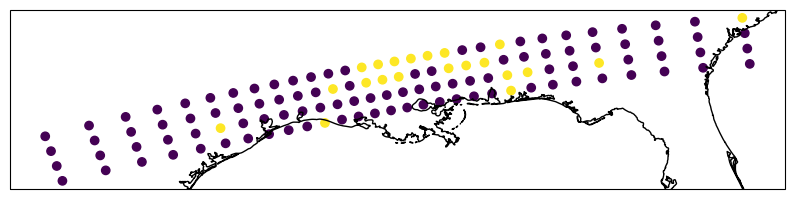

In [51]:
plt.figure(figsize=[10,5])
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()

plt.scatter(ds.Longitude, ds.Latitude, c=ds.Quality_Flag, vmin=0, vmax=1)

plt.show()

#### Step 4.1.1: A small diversion on creating custom color bar colors

Since the data above are not continuous (there are two values, Pass and Fail quality control), we might have to create a custom colorbar for the data using ```mpl.colors.ListedColormap```, which is part of **Matplotlib**. We can either define the colors manually using their hexadecimal values or extract values from the Matplotlib's built-in colormaps. Below is a list of two colors, which is then passed into ```ListedColormap``` along with a name for the color map.

If you want some advice on choosing colors, we recommend the [colorbrewer website](https://colorbrewer2.org/)!

In [52]:
# Create a new colormap
colors = ["#1b9e77", "#d95f02"]
my_cmap = mpl.colors.ListedColormap(colors, name="NUCAPS_QC")

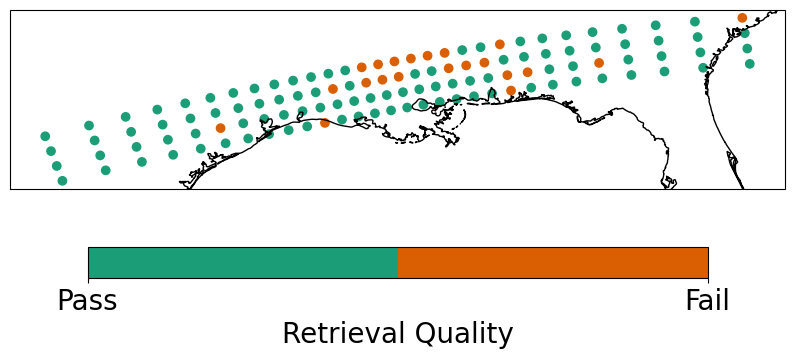

In [53]:
plt.figure(figsize=[10,5])
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()

cbar = plt.scatter(lon, lat, c=qf, vmin=0, vmax=1, cmap=my_cmap)

plt.colorbar(cbar, shrink=0.8, orientation='horizontal', ticks=range(2), label='Retrieval Quality').ax.set_xticklabels(['Pass', 'Fail'])

plt.show()

### Step 4.2: Extracting variables needed to create a Skew-T diagram

[Skew-T Log-P diagrams](https://www.weather.gov/source/zhu/ZHU_Training_Page/convective_parameters/skewt/skewtinfo.html) are a fast way of determining how stable the atmosphere is at a given location using profile measurements of temperature, moisture, and winds. Meteorologists routinely use [radiosondes](https://en.wikipedia.org/wiki/Radiosonde) attached to weather balloons for assimilation in weather models and to monitor for severe weather. Satellite sounding products like NUCAPS can measure temperature and moisture at about a 1km vertical resolution, but not winds. A [quick guide](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/QuickGuide_NUCAPS.pdf) is available to learn more about NUCAPS.

The Skew-T diagram enables quick calculations of several derived stability parameters, which include [Convective Available Potential Energy](https://en.wikipedia.org/wiki/Convective_available_potential_energy) (CAPE), Convective Inhibition (CIN). High values of CAPE and low values of CIN indicate the possibility of severe thunderstorms.


#### Step 4.2.1 Subsetting NUCAPS data using the pressure level and field of regard number

Each NUCAPS file contains 120 profiles, one for each field of regard (FOR), but we only want to plot one profile on a Skew-T. So, we will need to subset the file. We can use the ```isel``` module from **xarray** to use an index to extract a single profile from the larger array. We can also select more than one value either by passing a list of indices or using the ```slice()``` command which will extract a range of values. Below is an example of how to extract a single footprint and subset of pressure levels for the air temperature variable:

In [54]:
ds.Temperature.isel(Number_of_CrIS_FORs=0, Number_of_P_Levels=slice(80,87))

<xarray.DataArray 'Temperature' (Number_of_P_Levels: 7)>
[7 values with dtype=float32]
Coordinates:
    Time                datetime64[ns] ...
    Latitude            float32 27.9
    Longitude           float32 -101.1
    Pressure            (Number_of_P_Levels) float32 ...
    Effective_Pressure  (Number_of_P_Levels) float32 ...
Dimensions without coordinates: Number_of_P_Levels
Attributes:
    long_name:       Temperature
    standard_name:   air_temperature
    units:           Kelvin
    parameter_type:  NUCAPS data
    valid_range:     [   0. 1000.]

#### Step 4.2.2 Selecting a specific footprint

Let's assume we have a meteorologist colleague who asked us to look at a specific profile (```Number_of_CrIS_FORs=82```) because the forecasts models indicated there might be some instability there. We'll save this data in a variable called ```footprint```.

By footprint no longer has Number_of_CrIS_FORs listed as a dimension

In [55]:
footprint = ds.sel(Number_of_CrIS_FORs=82)
footprint

<xarray.Dataset>
Dimensions:               (Number_of_Ispares: 129, Number_of_Rspares: 298,
                           Number_of_Cloud_Layers: 8, Number_of_P_Levels: 100,
                           Number_of_MW_Spectral_Pts: 16,
                           Number_of_Surf_Emis_Hinge_Pts: 100,
                           Number_of_Stability_Parameters: 16,
                           Number_of_Cloud_Emis_Hing_Pts: 100)
Coordinates:
    Time                  datetime64[ns] ...
    Latitude              float32 31.67
    Longitude             float32 -87.03
    Pressure              (Number_of_P_Levels) float32 ...
    Effective_Pressure    (Number_of_P_Levels) float32 ...
Dimensions without coordinates: Number_of_Ispares, Number_of_Rspares,
                                Number_of_Cloud_Layers, Number_of_P_Levels,
                                Number_of_MW_Spectral_Pts,
                                Number_of_Surf_Emis_Hinge_Pts,
                                Number_of_Stability_Parameters,
                                Number_of_Cloud_Emis_Hing_Pts
Data variables: (12/64)
    quality_information   |S1 ...
    CrIS_FORs             float64 ...
    View_Angle            float32 ...
    Satellite_Height      float32 ...
    FG_Mean_CO2           float32 ...
    Mean_CO2              float32 ...
    ...                    ...
    FG_IR_Surface_Emis    (Number_of_Surf_Emis_Hinge_Pts) float32 ...
    IR_Surface_Refl       (Number_of_Surf_Emis_Hinge_Pts) float32 ...
    Stability             (Number_of_Stability_Parameters) float32 ...
    Cloud_Freq            (Number_of_Cloud_Layers, Number_of_Cloud_Emis_Hing_Pts) float32 ...
    Cloud_Emis            (Number_of_Cloud_Layers, Number_of_Cloud_Emis_Hing_Pts) float32 ...
    Cloud_Refl            (Number_of_Cloud_Layers, Number_of_Cloud_Emis_Hing_Pts) float32 ...
Attributes: (12/51)
    Conventions:                              CF-1.5
    Metadata_Conventions:                     CF-1.5, Unidata Datasset Discov...
    standard_name_vocabulary:                 CF Standard Name Table (version...
    project:                                  NPP Data Exploitation
    title:                                    NUCAPS_EDR
    summary:                                  NUCAPS retrieved profiles of te...
    ...                                       ...
    production_environment:                   OE
    number_valid_scans:                       4
    geospatial_bounds:                        POLYGON((-101.80 27.75, -93.65 ...
    instrument_resolution:                    CrIS 2211 channels
    number_valid_fovs:                        9
    retrieval_mode:                           IR+MW

#### Step 4.4.2 Extracting temperature, water vapor, and pressure & assigning units using MetPy

We'll use the ***MetPy*** package to create a Skew-T plot. Each skew T plot has two lines, temperature and dew point temperature, both as a function of pressure coordinates. NUCAPS has the air temperature variable and also water vapor mixing ratio. The water vapor mixing ratio needs to be converted to dew point temperature. We will also need to extract the vertical pressure.

**MetPy** builds on the **pint** library and [uses units](https://unidata.github.io/MetPy/latest/tutorials/unit_tutorial.html) to convenient perform numerous weather data calculations. 

Each variable above needs to be:
* extracted from the dataset
* all the same length
* assigned units

First let's examine the units in the NUCAPS file:

In [56]:
print(footprint.Temperature.values.shape, footprint.H2O_MR.shape, footprint.Pressure.shape)
print(footprint.Temperature.units, footprint.H2O_MR.units, footprint.Pressure.units)

(100,) (100,) (100,)
Kelvin kg/kg mb


The units convention in **pint** do not match those in the netcdf metadata conventions, we have to manually apply the units in the code block below.

While the NUCAPS temperature is reported in Kelvin, Skew-T plots conventionally use Celsius, so we convert from Kelvin to Celsius on the second line. 

Also note that we're using ```np.flip()``` below to reverse the data order. This is because the data need to indexed from the surface to the top of the atmosphere for some of our later calculations. NUCAPS profiles are stored from the top of the atmosphere to the surface.

In [57]:
T = np.flip(footprint.Temperature.values)
T= T*units('K')
T=T.to(units.celsius)

MR = np.flip(footprint.H2O_MR.values)
MR = MR*units('kg/kg')

P = np.flip(footprint.Pressure.values)
P = P*units('millibar')

#### Step 4.4.3: Convert between units using MetPy

We'll have to use two functions to convert mixing ratio to dewpoint temperature. We first the water vapor mixing ratio convert to relative humidity (using ```mpcalc.relative_humidity_from_mixing_ratio```) and then we convert from relative humidity to dew point (using ```mpcalc.dewpoint_from_relative_humidity```). 

Note: You might see an warning below - this is because near the top of the atmosphere, there is very little water vapor and log(0) is undefined. The warning will not impact the rest of the code.

In [58]:
RH = mpcalc.relative_humidity_from_mixing_ratio(P, T, MR)
Td = mpcalc.dewpoint_from_relative_humidity(T, RH)

/home/rebekah/miniconda3/envs/notebook_demo/lib/python3.11/site-packages/metpy/calc/thermo.py:1114: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


#### Step 4.4.4: Creating a mask to account for surface pressure & the top of the atmosphere

The NUCAPS data are reported on a fixed pressure grid that spans from 0-1100 mb, which does not account for local topography. So, we will need to mask out values below the surface pressure, which is in the ```Surface_Pressure``` variable, and create a mask where ```P < Psurf``` (since Pressure decreases with height) (note: this process has been simplified for the purposes of the short course, here are full details on estimating the [surface pressure in NUCAPS](https://www.mdpi.com/2072-4292/12/20/3311)). We also remove all data above 100 mb since this above the planetary boundary layer.

In [59]:
Psurf = footprint.Surface_Pressure.item()*units('millibar')
mask = (P < Psurf) & (P > 100*units('millibar'))

#### Step 4.4.5: Applying the mask to NUCAPS profiles

We'll want only show temperature and water vapor data that are above the surface pressure. So, let's apply the mask to temperature, pressure, and dew point temperature:

In [60]:
P1 = P[mask]
T1 = T[mask]
Td1 = Td[mask]

In [61]:
P1.shape

(53,)

## Topic 5-6: Making Composite (RGB) Images & Working with Map Projections

These steps do not apply since we're working with hyperspectal sounder data! Images have 16 channels that span broader wavelength bands, hyperspectral sounders can have thousands of tiny bands. However, we can still apply what we learned about professional touches to images (Topic 7) to our Skew-T plots.

## Topic 8: Creating Skew-T/Log-P Plots

### Step 8.1: Create a simple Skew-T

Finally, let's make a skew-T plot! The only new command is ```SkewT()```, which will return an axis that is projected onto the rotated Skew-T grid. We need two lines, one for temperature and one for dew point temperature.

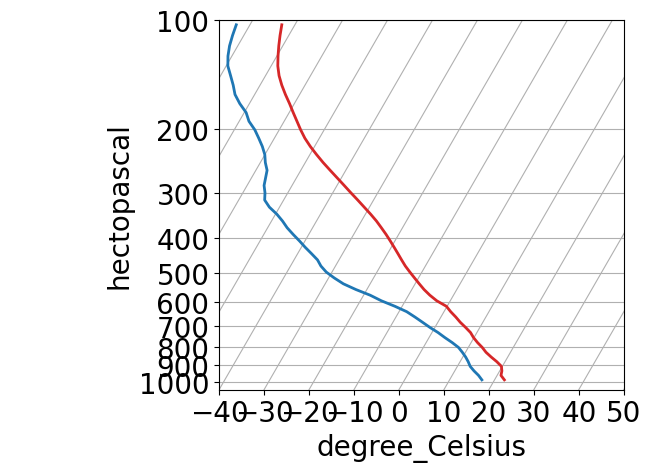

In [62]:
fig = plt.figure()
skew = SkewT(fig)

skew.plot(P1, T1, label='Temperature', color='tab:red', lw=2)
skew.plot(P1, Td1, label='Dewpoint',  color='tab:blue', lw=2)

plt.show()

### Step 8.2: Adding the parcel profile

One of the benefits of the Skew-T diagram is we can quickly compare the environmental Temperature and Dew Point temperature with that of an adiabatic parcel, which can be added to our SkewT as a third line. MetPy conveniently also calculate the parcel profile using the surface temperature, dew point, and their pressure profile. The output is initially in Kelvin, so we convert back to Celsius using ```to('degC')```.

In [63]:
# Shade CAPE/CIN
prof = mpcalc.parcel_profile(P1, T1[0], Td1[0]).to('degC')

### Step 8.3: Adding labels for retrieval time and location, data units

We have our parcel profile, but let's add a few addition professional touches to our plot. We'll add a title showing what time (```Time```) the profile was taken as well as the location (```Latitude``` and ```Longitude```). We'll use the strftime to convert the date time to display the day, month name, and year. We round the latitude and longitude to a single decimal place using ```round()``` since the original has more precision than is visually necessary. 

In [64]:
timestr = footprint.Time.dt.strftime('%d %b %Y %H:%M UTC').item()
locstr = "("+str(footprint.Latitude.values.round(1))+"$^\circ$N, "+str(np.abs(footprint.Longitude.values.round(1)))+"$^\circ$W)"

We combine the two string above into a single title. Let's also improve the look of the x and y axis. Finally, we'll increase the font size so it's easier to read. We can update the font size for **all** our plots in our notebook by using ```plt.rcParams.update()```.

In [65]:
title = "NUCAPS "+timestr+" "+locstr
xlabel = 'Temperature ($^\circ$C)'
ylabel = 'Pressure (mb)'

plt.rcParams.update({'font.size': 20})

### Step 8.4: Creating a Skew-T with parcel profiles, a title, and axes labels

Below we reuse the code from step 8.1 as the starting point. Some new features are the addition of a legend, explicit x and y limits, the parcel profile line, and the labels that we generated: 

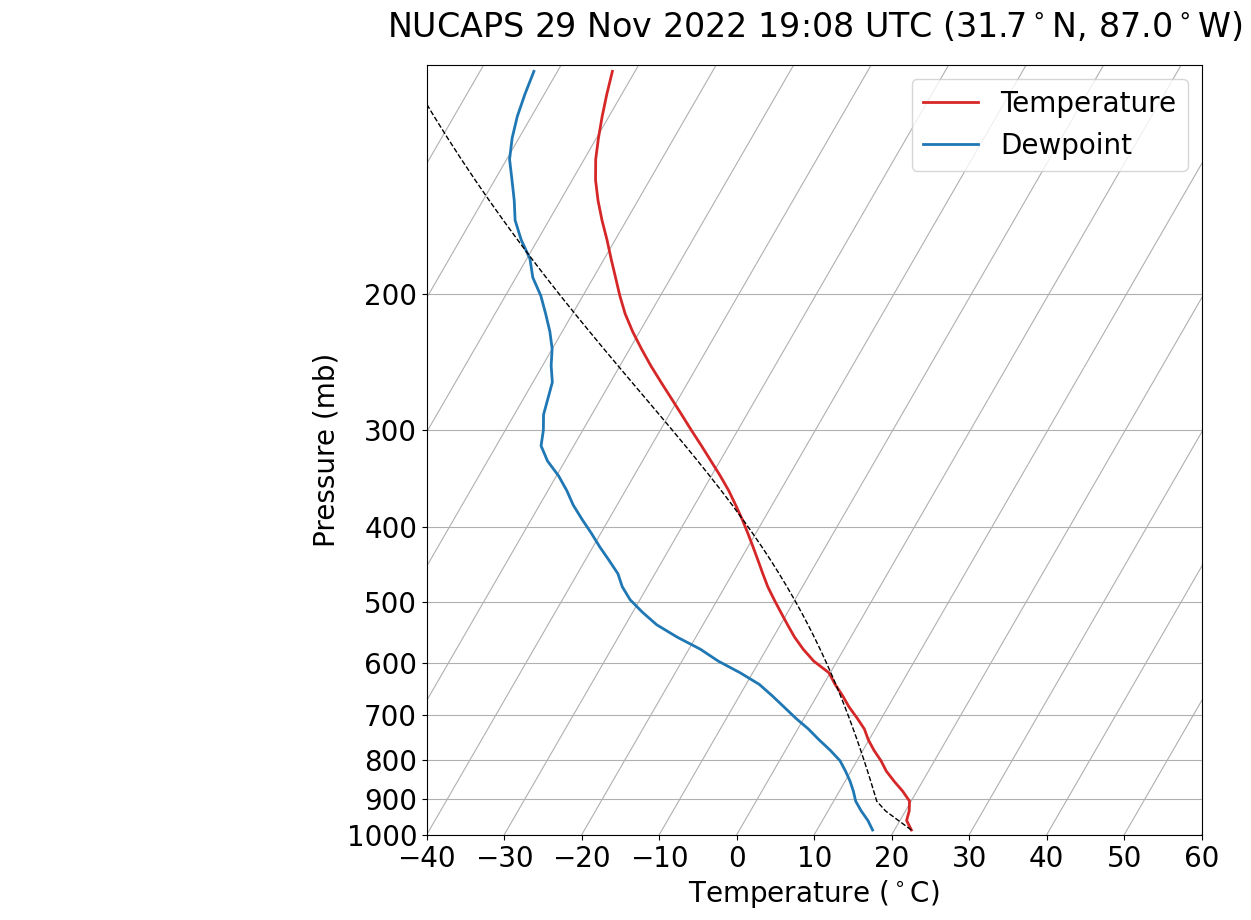

In [66]:
# Make plot -------
fig = plt.figure(figsize=(10,10))
skew = SkewT(fig, aspect='auto')

skew.plot(P1, T1, label='Temperature', color='tab:red', lw=2)
skew.plot(P1, Td1, label='Dewpoint',  color='tab:blue', lw=2)

skew.ax.legend(loc='upper right')

skew.ax.set_ylim(1000, 101)
skew.ax.set_xlim(-40, 60)

# Plot parcel profile
skew.plot(P1, prof, c='k', linewidth=1, markersize=1, linestyle='dashed')

skew.ax.set_xlabel('Temperature ($^\circ$C)')
skew.ax.set_ylabel('Pressure (mb)')
skew.ax.set_title(title, pad=20)

plt.show()

### Step 8.5: Calculating & labelling derived parameters

For calculating CAPE, there are three important parameters, which per the [National Weather Service glossary](https://forecast.weather.gov/glossary.php) are:

* Lifted Condensation Level (LCL): The pressure level at which a parcel of moist air becomes saturated when it is lifted dry adiabatically. This is the level in the atmosphere clouds will can form.
* Level of Free Convection (LFC): The pressure level at which parcel of saturated air becomes warmer than the surrounding air and begins to rise freely.
* Equilibrium Level (EL): The pressure level where the temperature of a rising air parcel again equals the temperature of the environment. This represents the top of thunderstorm updrafts.

We can also these these values to calculate:

* Convective Available Potential Energy (CAPE). A measure of the amount of energy available for convection. Higher values indicate greater potential for severe weather.
* Convective INhibition (CIN). A measure of the amount of energy needed in order to initiate convection. High values decrease the potential for severe weather.

There are a few ways to calculate CAPE, below we'll show surface-based CAPE.

#### Step 8.5.1: Calculating LCL, LFC, EL, CAPE, and CIN with MetPy

We can employ **MetPy** to make calculate the LCL, LFC, EL, CAPE, and CIN:

In [67]:
# Calc lcl, cape vals
lcl_pressure, lcl_temperature = mpcalc.lcl(P1[0], T1[0], Td1[0])
lfc_pressure, lfc_temperature = mpcalc.lfc(P1, T1, Td1)
el_pressure, el_temperature = mpcalc.el(P1, T1, Td1)

sfc_cape, sfc_cin = mpcalc.surface_based_cape_cin(P1, T1, Td1)

#### Step 8.5.2: Annotating plot with CAPE/CIN values

LCL, LFC, and EL are expressed as points on the skew-T. We can add them to our plot using ```skew.plot()```.

CAPE and CIN are calculated by integrating the area between the parcel line and environmental temperature line. Again, we use the ```round()``` command to show only two decimal places to avoid excessive precision. Let's create an annotation that displays the CAPE and CIN values. You may notice a 

In [68]:
cape_label = 'SFC. CAPE: '+str(sfc_cape.magnitude.round())+' J/kg'
cin_label = 'SFC. CIN: '+str(sfc_cin.magnitude.round())+' J/kg'

cape_cin_label = cape_label + '\n' + cin_label
cape_cin_label

'SFC. CAPE: 244.0 J/kg\nSFC. CIN: -228.0 J/kg'

### Step 8.6: Adding the professional touches to the SkewT

The top half of the code below is identical to Step 8.4.

In addition to adding LCL, LFC, and EL points to the plot using ```skew.plot()```, we also annotate them using ```skew.ax.annotate()```. 

We also shade the areas that represent CAPE and CIN and annotate the values that each represents.


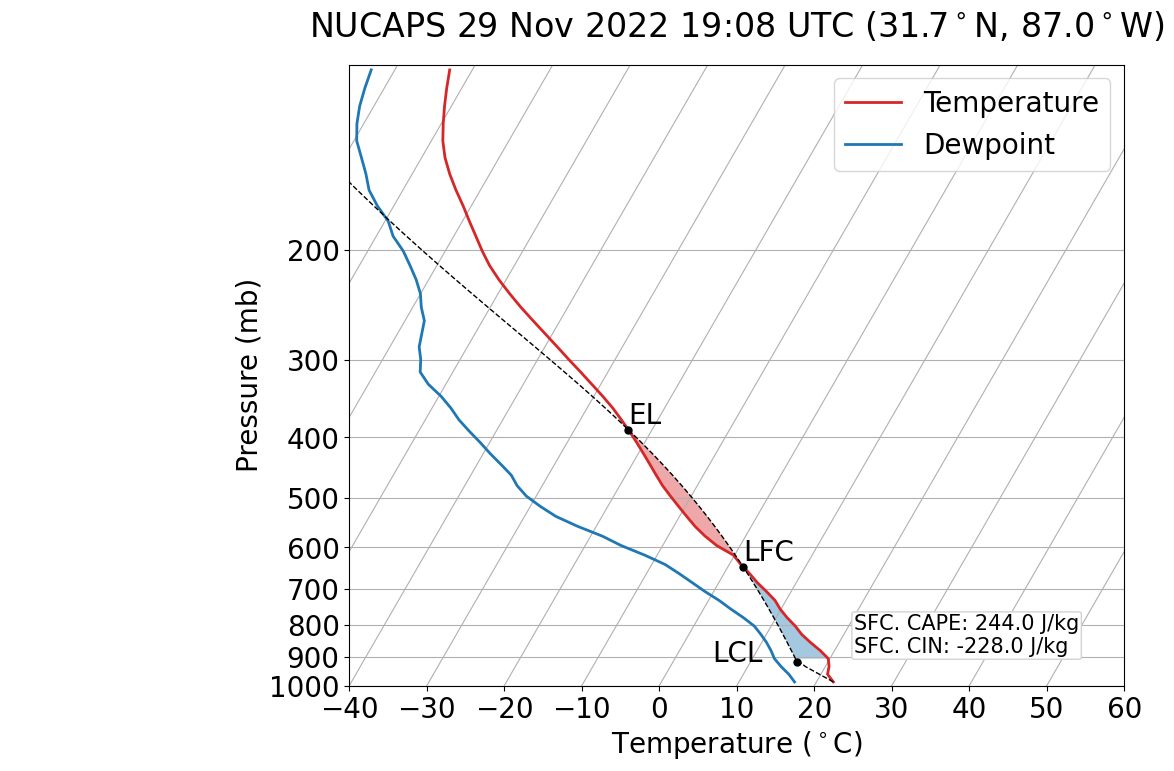

In [69]:
fig = plt.figure(figsize=(10,10))
skew = SkewT(fig)

skew.plot(P1, T1, label='Temperature', color='tab:red', lw=2)
skew.plot(P1, Td1, label='Dewpoint',  color='tab:blue', lw=2)

skew.ax.legend(loc='upper right')

skew.ax.set_ylim(1000, 101)
skew.ax.set_xlim(-40, 60)

skew.plot(P1, prof, c='k', linewidth=1, markersize=1, linestyle='dashed')

skew.ax.set_xlabel('Temperature ($^\circ$C)')
skew.ax.set_ylabel('Pressure (mb)')
skew.ax.set_title(title, pad=20)

# Plot EL, LFC, LCL
skew.plot(el_pressure, el_temperature, marker='.', c='k', markersize=10)
skew.plot(lfc_pressure, lfc_temperature, marker='.', c='k', markersize=10)
skew.plot(lcl_pressure, lcl_temperature, marker='.', c='k', markersize=10)

# Annotate EL, LFC, LCL
skew.ax.annotate('EL', xy=(el_temperature, el_pressure), va="bottom", ha="left")
skew.ax.annotate('LFC', xy=(lfc_temperature, lfc_pressure), va="bottom", ha="left")
skew.ax.annotate('LCL', xy=(5, lcl_pressure))

# Shade areas of CAPE and CIN
skew.shade_cin(P1, T1, prof, Td1)
skew.shade_cape(P1, T1, prof)

# Plot sfc cape/cin values
skew.ax.annotate(cape_cin_label, xy=(23, 900), va="bottom", ha="left", size=15, bbox=dict(boxstyle="round, pad=0.1", fc="white", ec="lightgrey", lw=1))


plt.show()